# Forecasting

Forecast the PM2.5 value of next day from last 7 days data.

In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
demo_city_name = 'ubonratchathani'

In [19]:
region_df = pd.read_csv('dataset/berkeleyearth/region.csv')
region_df.rename({'Unnamed: 0': 'id'}, axis=1, inplace=True)
raw_sensor_df = pd.read_csv('dataset/berkeleyearth/sensor.csv')
raw_sensor_df.rename({'Unnamed: 0': 'id'}, axis=1, inplace=True)
raw_sensor_df['timestamp'] = pd.to_datetime(raw_sensor_df['timestamp'])


In [4]:
raw_sensor_df.tail(10)

,id,city,timestamp,pm
1568091,1568091,yala,2019-12-31 23:00:00,14.2
1568092,1568092,yala,2020-01-01 01:00:00,10.5
1568093,1568093,yala,2020-01-01 02:00:00,14.1
1568094,1568094,yala,2020-01-01 03:00:00,14.2
1568095,1568095,yala,2020-01-01 04:00:00,13.5
1568096,1568096,yala,2020-01-01 05:00:00,13.7
1568097,1568097,yala,2020-01-01 06:00:00,9.6
1568098,1568098,yala,2020-01-01 07:00:00,9.6
1568099,1568099,yala,2020-01-01 08:00:00,9.7
1568100,1568100,yala,2020-01-01 09:00:00,9.6


In [5]:
raw_sensor_df['pm'].describe()

count    1.568101e+06
mean     2.408888e+01
std      1.553467e+01
min      6.000000e-01
25%      1.360000e+01
50%      1.950000e+01
75%      3.010000e+01
max      7.879000e+02
Name: pm, dtype: float64

## Initialize Standard Scaler

In [6]:
from sklearn.externals import joblib

/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [7]:
scaler = StandardScaler()
scaler.fit(raw_sensor_df['pm'].to_numpy().reshape((-1, 1)))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [8]:
# joblib.dump(scaler, 'scaler.pkl')

In [9]:
scaler = joblib.load('scaler.pkl')

# Resample & Interpolation

Resample frequency of PM2.5 data from hourly to daily with mean and interpolate the missing data with mean.

In [10]:
def daily_mean_interpolate(df):
    df = df.drop('id', axis=1).set_index('timestamp').resample('D').mean()
    df['pm'] = df['pm'].interpolate()
    return df.reset_index()
sensor_df = raw_sensor_df.groupby('city').apply(daily_mean_interpolate)

In [11]:
sensor_df.head(10)

timestamp         pm
city                           
bangkok 0 2016-03-03  45.120000
        1 2016-03-04  34.791667
        2 2016-03-05  31.283333
        3 2016-03-06  29.679167
        4 2016-03-07  29.591667
        5 2016-03-08  27.787500
        6 2016-03-09  29.270833
        7 2016-03-10  27.978261
        8 2016-03-11  21.045833
        9 2016-03-12  20.508333

## Before Resample and Interpolation

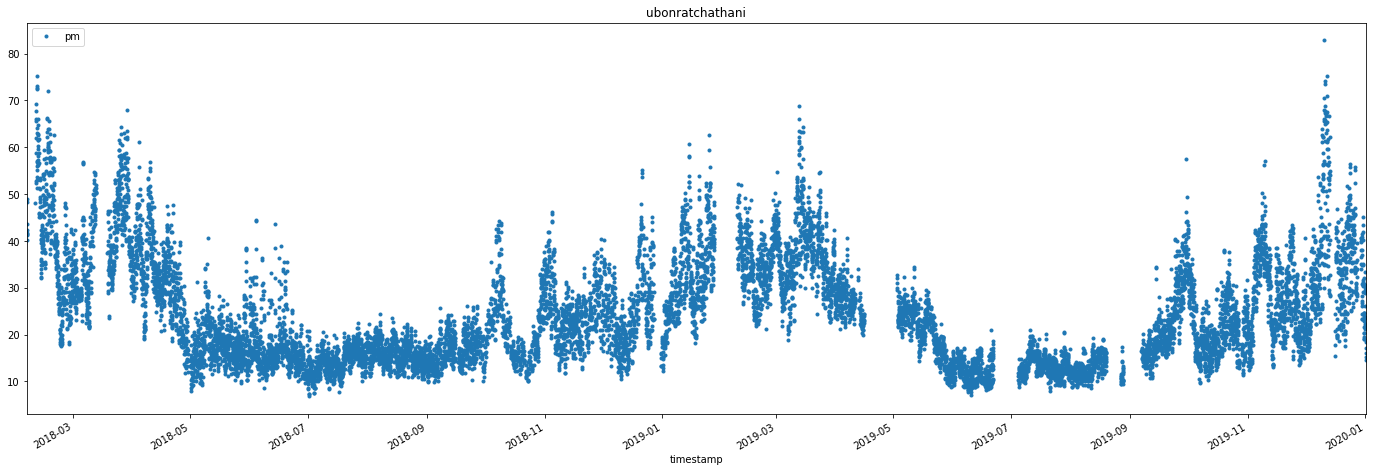

In [22]:
raw_sensor_df[raw_sensor_df['city'] == demo_city_name].plot(
    x='timestamp', y='pm', style='.', figsize=(24, 8), title=demo_city_name)

## After Resample and Interpolation

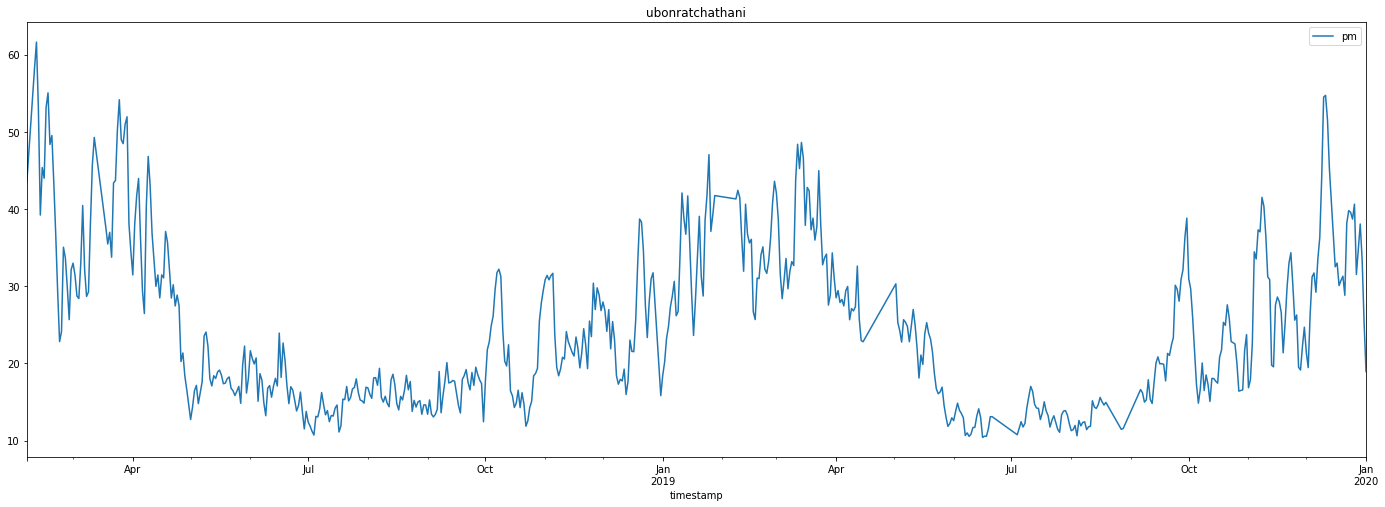

In [13]:
sensor_df.loc[demo_city_name].plot(
    x='timestamp', y='pm', figsize=(24, 8), title=demo_city_name)

# Standardize

In [25]:
pm = sensor_df['pm'].to_numpy().reshape((-1, 1))
sensor_df['pm'] = scaler.transform(pm)

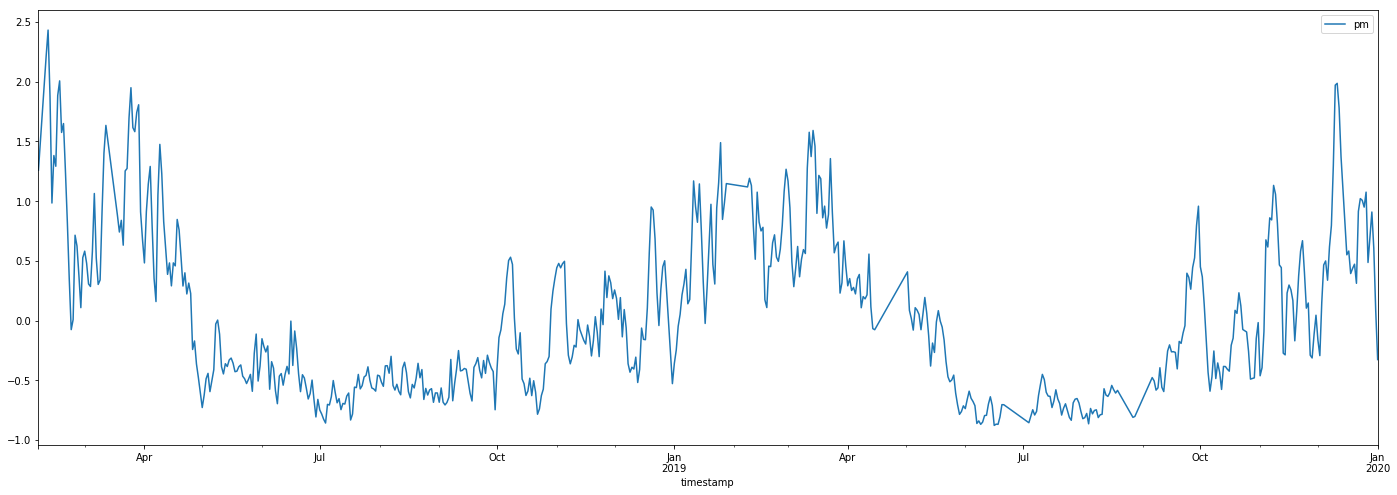

In [26]:
sensor_df.loc[demo_city_name].plot(x='timestamp', y='pm', figsize=(24, 8))

# Train & Test split

In [27]:
val_split_date = '2019-06-01'
test_split_date = '2019-09-15'
train_sensor = sensor_df[sensor_df['timestamp'] < val_split_date]
val_sensor = sensor_df[(sensor_df['timestamp'] >= val_split_date) & (sensor_df['timestamp'] < test_split_date)]
test_sensor = sensor_df[sensor_df['timestamp'] >= test_split_date]

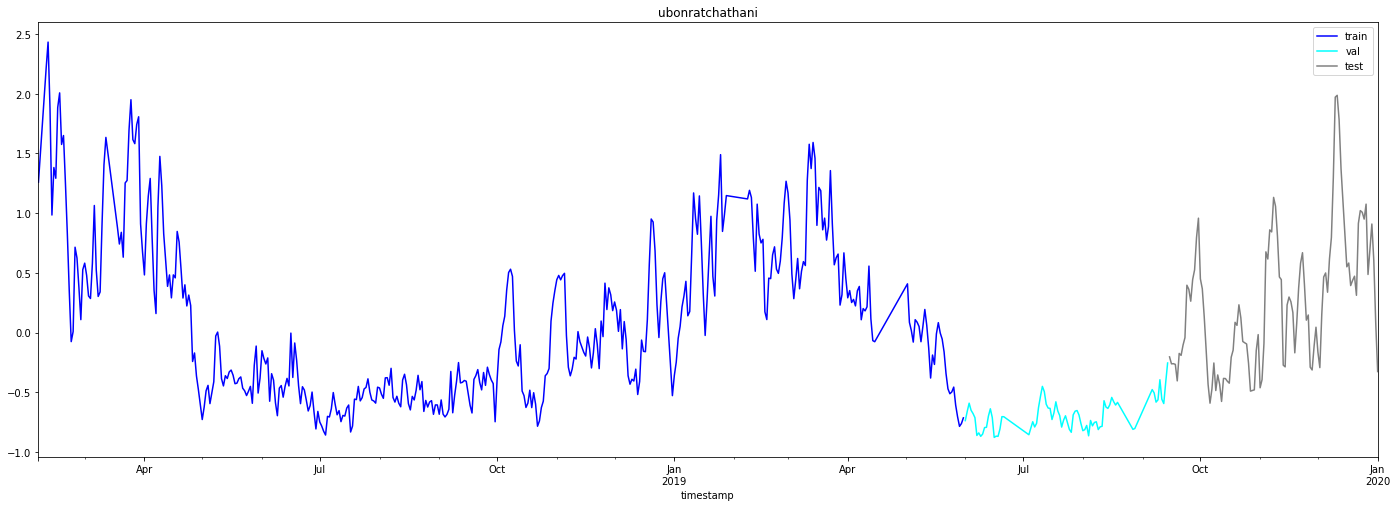

In [28]:
train_city = train_sensor.loc[demo_city_name]
val_city = val_sensor.loc[demo_city_name]
test_city = test_sensor.loc[demo_city_name]
ax = train_city.plot(x='timestamp', y='pm', color='blue',
                     kind='line', label='train')
ax = val_city.plot(x='timestamp', y='pm', color='cyan', kind='line',
               title=demo_city_name, label='val', figsize=(24, 8), ax=ax)
ax = test_city.plot(x='timestamp', y='pm', color='grey', kind='line',
               title=demo_city_name, label='test', figsize=(24, 8), ax=ax)

# Sliding window

In [30]:
window_size = 7
output_size = 1
stride = 1
batch_size = 32
shuffle = False



def sliding_window(city_sensor, window_size, output_size, stride):
    city_sensor = city_sensor.sort_values('timestamp')
    pm_series = city_sensor['pm'].to_numpy()

    xs = []
    ys = []
    for i in range(0, len(pm_series)-window_size-output_size+1, stride):
        x = pm_series[i: i+window_size]
        y = pm_series[i+window_size: i+window_size+output_size]

        xs.append(x)
        ys.append(y)
    xs = np.array(xs)
    xs = np.expand_dims(xs, axis=2)
    ys = np.array(ys)

    return xs, ys


def create_all_city(sensor, window_size, output_size, stride):
    data = sensor.groupby('city').apply(
        sliding_window, window_size, output_size, stride).to_numpy()
    
    xs = []
    ys = []
    for (x, y) in data:
        xs.append(x)
        ys.append(y)
    xs = np.concatenate(xs, axis=0)
    ys = np.concatenate(ys, axis=0)
    return xs, ys

X, Y = create_all_city(train_sensor, window_size, output_size, stride)
val_X, val_Y = create_all_city(val_sensor, window_size, output_size, stride)
test_X, test_Y = create_all_city(test_sensor, window_size, output_size, stride)

In [32]:
X[0], Y[0]

(array([[1.36596548],
        [0.69845612],
        [0.47171622],
        [0.36804061],
        [0.36238557],
        [0.24578417],
        [0.34165045]]), array([0.25811285]))

In [33]:
X[1], Y[1]

(array([[0.69845612],
        [0.47171622],
        [0.36804061],
        [0.36238557],
        [0.24578417],
        [0.34165045],
        [0.25811285]]), array([-0.18992268]))

# Model 

Create forecasting model. We use LSTM for forecasting.

In [24]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, GRU, Input


In [ ]:
model = Sequential()
model.add(LSTM(8, return_sequences=True, input_shape=(7, 1)))
model.add(LSTM(4))
model.add(Dense(1))

In [25]:
model = load_model('model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [26]:
model.compile(optimizer='adam', loss='mse', )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 7, 8)              320       
_________________________________________________________________
lstm_9 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [342]:
model.fit(X, Y, validation_data=(val_X, val_Y), shuffle=True, epochs=10)

Train on 64152 samples, validate on 5544 samples
Epoch 1/10
64152/64152 [==============================] - 21s 334us/step - loss: 0.1816 - val_loss: 0.0261
Epoch 2/10
64152/64152 [==============================] - 19s 298us/step - loss: 0.1233 - val_loss: 0.0278
Epoch 3/10
64152/64152 [==============================] - 19s 295us/step - loss: 0.1224 - val_loss: 0.0268
Epoch 4/10
64152/64152 [==============================] - 18s 287us/step - loss: 0.1218 - val_loss: 0.0249
Epoch 5/10
64152/64152 [==============================] - 19s 292us/step - loss: 0.1213 - val_loss: 0.0247
Epoch 6/10
64152/64152 [==============================] - 19s 293us/step - loss: 0.1212 - val_loss: 0.0249
Epoch 7/10
64152/64152 [==============================] - 19s 296us/step - loss: 0.1208 - val_loss: 0.0255
Epoch 8/10
64152/64152 [==============================] - 19s 294us/step - loss: 0.1208 - val_loss: 0.0247
Epoch 9/10
64152/64152 [==============================] - 18s 284us/step - loss: 0.1205 - val_l

In [260]:
model.save('model.h5')

In [27]:
def predict_city(city_sensor, scaler=None):
    city_sensor = city_sensor.copy()
    x, y = sliding_window(city_sensor, window_size, output_size, stride)
    y_pred = model.predict(x, verbose=0)
    
    if scaler is not None:
        y_pred = scaler.inverse_transform(y_pred)
        city_sensor['pm'] = scaler.inverse_transform(city_sensor['pm'])
    
    city_sensor['pm_pred'] = np.nan
    city_sensor['pm_pred'][window_size-1:-1] = np.squeeze(y_pred)
    
    return city_sensor

# Evaluation

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [29]:
def root_mean_squared_error(*args):
    return np.sqrt(mean_squared_error(*args))

In [30]:

def evaluate(city_sensor, metric_func):
    city_sensor = city_sensor.dropna()
    score = metric_func(city_sensor['pm'], city_sensor['pm_pred'])
    return score

def add_evaluatation_metrics(metrics, sensor, metric_func, column_name):
    sensor = sensor.copy()
    sensor = sensor.groupby('city').apply(predict_city, scaler)
    score_series = sensor.groupby('city').apply(evaluate, metric_func)
    score_df = score_series.to_frame(column_name)
    return pd.merge(metrics, score_df, on='city')

In [343]:
metrics = pd.DataFrame(
    data=raw_sensor_df['city'].drop_duplicates().sort_values(), columns=['city'])
metrics = add_evaluatation_metrics(metrics, train_sensor, mean_squared_error, 'train_mse')
metrics = add_evaluatation_metrics(metrics, train_sensor, root_mean_squared_error, 'train_rmse')
metrics = add_evaluatation_metrics(metrics, train_sensor, mean_absolute_error, 'train_mae')
metrics = add_evaluatation_metrics(metrics, val_sensor, mean_squared_error, 'val_mse')
metrics = add_evaluatation_metrics(metrics, val_sensor, root_mean_squared_error, 'val_rmse')
metrics = add_evaluatation_metrics(metrics, val_sensor, mean_absolute_error, 'val_mae')
metrics = add_evaluatation_metrics(metrics, test_sensor, mean_squared_error, 'test_mse')
metrics = add_evaluatation_metrics(metrics, test_sensor, root_mean_squared_error, 'test_rmse')
metrics = add_evaluatation_metrics(metrics, test_sensor, mean_absolute_error, 'test_mae')


In [344]:
metrics

,city,train_mse,train_rmse,train_mae,val_mse,val_rmse,val_mae,test_mse,test_rmse,test_mae
0,bangkok,3.037345,1.742798,1.105780,0.604849,0.777720,0.643801,3.038464,1.743119,1.274314
1,bangkruai,3.251049,1.803067,1.140336,0.699704,0.836483,0.700961,3.713049,1.926927,1.391051
2,banlamlukka,3.053627,1.747463,1.116681,0.796412,0.892419,0.764101,2.107981,1.451889,1.107442
3,banmai,0.628418,0.792728,0.599154,1.202398,1.096539,0.784737,1.810143,1.345415,0.972918
4,banpong,4.091202,2.022672,1.277344,1.157667,1.075949,0.927386,5.211560,2.282884,1.609565
5,bantalatyai,0.858031,0.926300,0.705576,1.195513,1.093395,0.894146,2.498071,1.580529,1.292862
6,chaiyaphum,3.269606,1.808205,1.110243,0.498400,0.705974,0.594606,3.325676,1.823644,1.267463
7,chanthaburi,1.084233,1.041265,0.753313,0.841387,0.917272,0.854449,0.752576,0.867511,0.676878
8,chiangmai,14.117774,3.757363,1.984831,1.070622,1.034708,0.890734,1.001485,1.000742,0.771778
9,chiangrai,34.968874,5.913449,2.454458,1.750746,1.323158,1.231413,0.789288,0.888419,0.741121


# Visualization

Visualize PM2.5 forecasting. Using dot represent truth value and line represent forecasted value.

In [31]:
def visualize_city(city_name):
    train_city_sensor = train_sensor.loc[city_name]
    val_city_sensor = val_sensor.loc[city_name]
    test_city_sensor = test_sensor.loc[city_name]
    

    train_city_sensor = predict_city(train_city_sensor, scaler)
    val_city_sensor = predict_city(val_city_sensor, scaler)
    test_city_sensor = predict_city(test_city_sensor, scaler)
    
    ax = None
    ax = train_city_sensor.plot(x='timestamp', y='pm',
                                figsize=(24, 8), color='blue', style='.', label='train_truth_pm', ax=ax)
    ax = train_city_sensor.plot(
        x='timestamp', y='pm_pred', figsize=(24, 8), color='orange', label='train_pred_pm', ax=ax)

    ax = val_city_sensor.plot(x='timestamp', y='pm', figsize=(
        24, 8), color='red', style='.', label='val_truth_pm', ax=ax)
    ax = val_city_sensor.plot(x='timestamp', y='pm_pred',
                         figsize=(24, 8), color='orange', label='val_pred_pm', ax=ax, title=city_name)
    
    ax = test_city_sensor.plot(x='timestamp', y='pm', figsize=(
        24, 8), color='black', style='.', label='test_truth_pm', ax=ax)
    ax = test_city_sensor.plot(x='timestamp', y='pm_pred',
                         figsize=(24, 8), color='orange', label='test_pred_pm', ax=ax, title=city_name)
    return ax


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.i

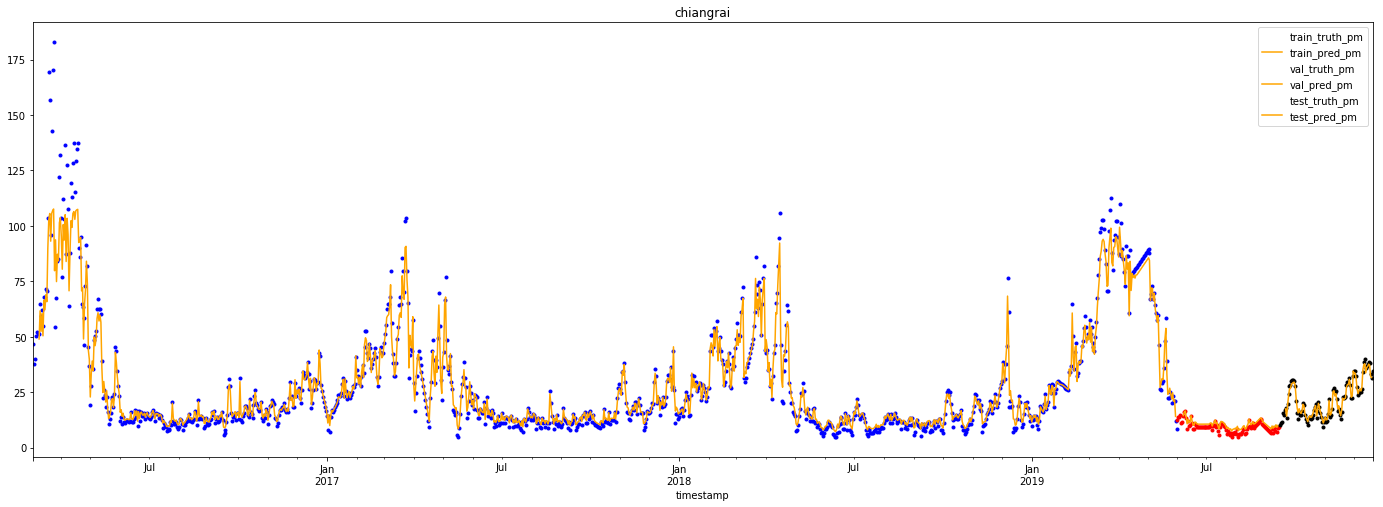

In [32]:
visualize_city('chiangrai')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.i

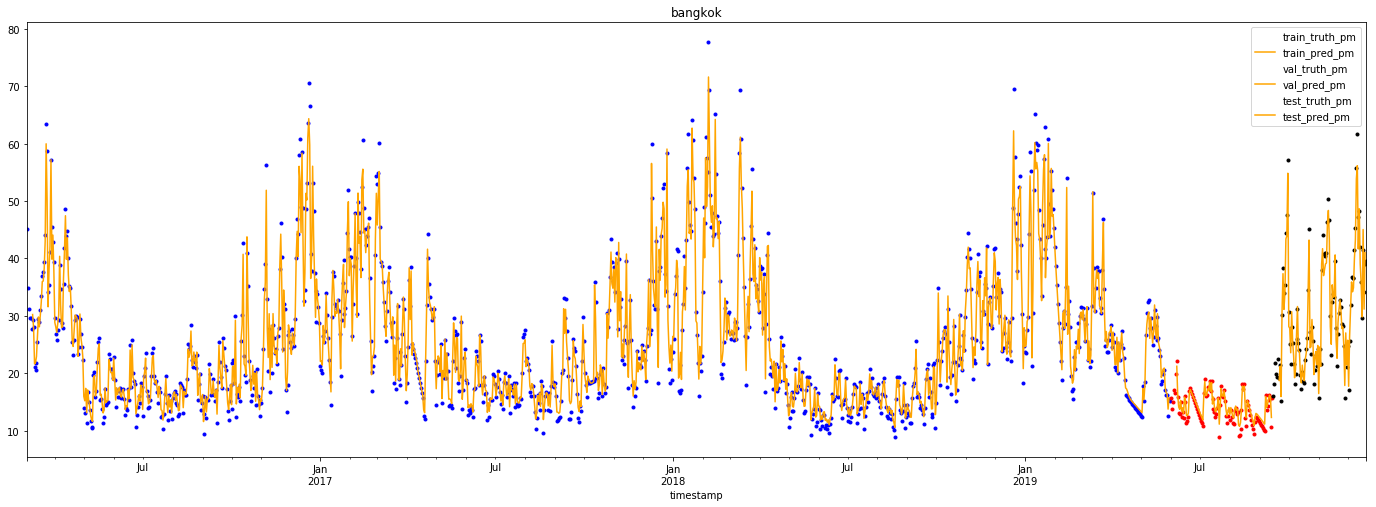

In [33]:
visualize_city('bangkok')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.i

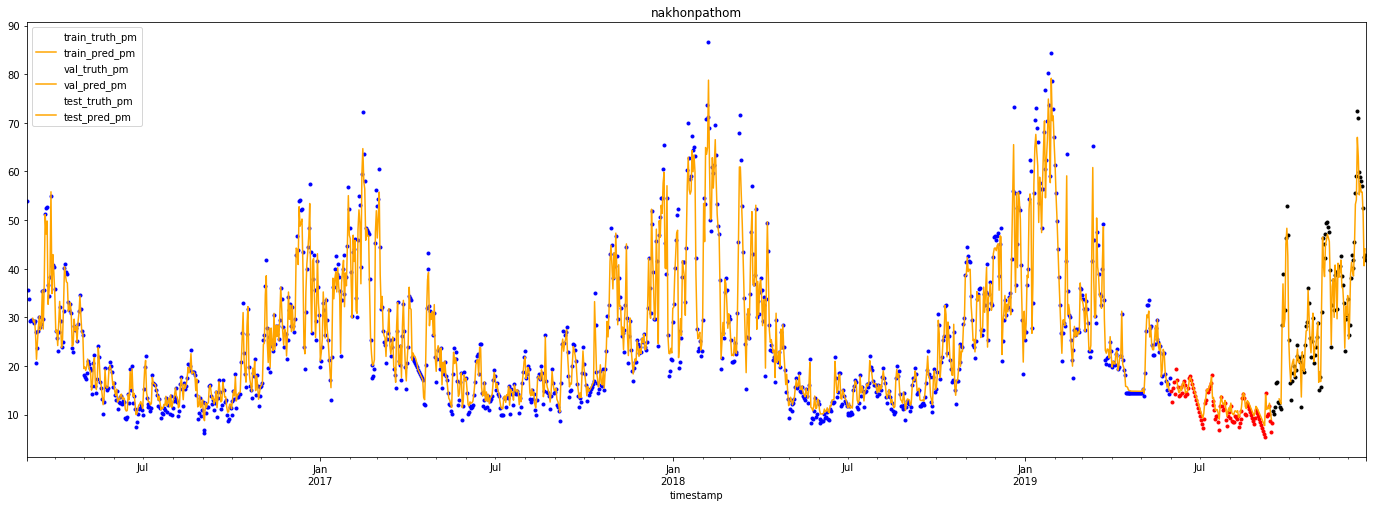

In [34]:
visualize_city('nakhonpathom')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.i

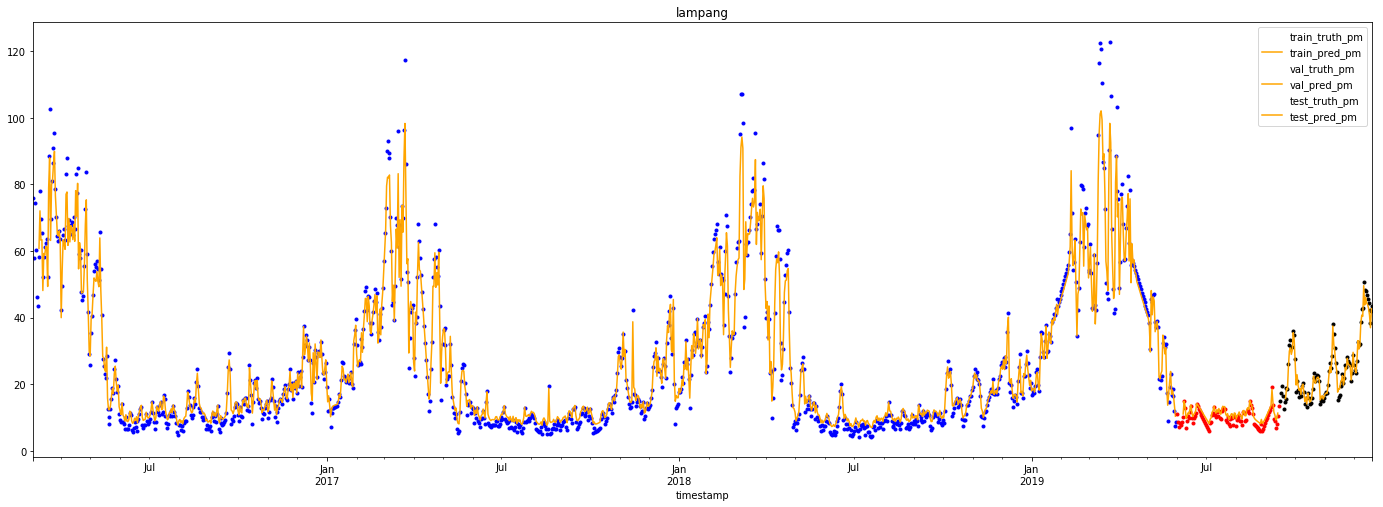

In [35]:
visualize_city('lampang')